# VGG16 model to classify clothing category

In [1]:
import os
import sys
import glob
import h5py
import argparse
import matplotlib.pyplot as plt
%matplotlib inline

import keras
from keras import __version__
from keras.applications.vgg16 import VGG16,preprocess_input
from keras.models import Model
from keras.preprocessing import image
from keras.models import model_from_json
from keras.layers import Dense, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.training_utils import multi_gpu_model
from keras.optimizers import SGD

from keras.preprocessing.image import load_img,img_to_array
from keras.applications.vgg16 import decode_predictions
from keras.models import load_model

import operator
%pylab inline
import matplotlib.image as mpimg

import pickle 

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))
Using TensorFlow backend.


Populating the interactive namespace from numpy and matplotlib


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['__version__']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
# setting parameters
image_width, image_height = 224, 224 #fixed size for VGG16 model
epochs = 20
batch_size = 100
neurons = 512
classes = 5
train_samples = 1000
val_samples = 250

train_dir = './train'
test_dir = './test'

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input)


train_generator = train_datagen.flow_from_directory(
 train_dir,
 target_size=(image_width, image_height),
 batch_size=batch_size)

validation_generator = test_datagen.flow_from_directory(
 test_dir,
 target_size=(image_width, image_height),
 batch_size=batch_size,)



Found 89355 images belonging to 5 classes.
Found 26385 images belonging to 5 classes.


In [12]:
# instantiate pretrained VGG16 model, chop off the last layer
base_model = VGG16(weights='imagenet', include_top=False)


# add the last layer to classify 5 class clothing problem
def add_new_last_layer(base_model, classes, neurons):

    x = base_model.output
    
    # reduce the computation complexity 
    x = GlobalAveragePooling2D()(x) 
           
    # adds on a fully-connected Dense layer to increase prediction accuracy
    x = Dense(neurons, activation='relu',name='l2')(x) 
    
    # adds a softmax function on the output to squeeze the values between [0,1]
    predictions = Dense(classes, activation='softmax',name='last')(x) 
        
    model = Model(input=base_model.input, output=predictions)
    
    return model

    
    
model = add_new_last_layer(base_model, classes, neurons)



def setup_to_finetune(model):
    
    #freeze the layers from VGG16 model, and free the last three layers that we added
    for layer in model.layers[:-3]:
        layer.trainable = False
    for layer in model.layers[-3:]:
        layer.trainable = True
        
    model.compile(optimizer='adam',   
                 loss='categorical_crossentropy',metrics = ['accuracy'])



## Training
setup_to_finetune(model)

#set up early stopping to prevent overfitting 
cb=keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=4, verbose=0, mode='auto')

history = model.fit_generator(
 train_generator,
 samples_per_epoch=train_samples,
 nb_epoch=epochs,
 validation_data=validation_generator, callbacks=[cb])


model.save("vgg16final.h5")

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:19: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("la...)`
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:52: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:52: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras.pre..., validation_data=<keras.pre..., callbacks=[<keras.ca..., steps_per_epoch=6, epochs=20)`


Epoch 1/20
6/6 [==============================] - 9s 1s/step - loss: 1.9966 - acc: 0.4333 - val_loss: 0.7198 - val_acc: 0.7533
Epoch 2/20
6/6 [==============================] - 8s 1s/step - loss: 1.1615 - acc: 0.6556 - val_loss: 0.2914 - val_acc: 0.9133
Epoch 3/20
6/6 [==============================] - 8s 1s/step - loss: 0.5384 - acc: 0.8222 - val_loss: 0.5253 - val_acc: 0.8467
Epoch 4/20
6/6 [==============================] - 8s 1s/step - loss: 0.3690 - acc: 0.8778 - val_loss: 0.1775 - val_acc: 0.9333
Epoch 5/20
6/6 [==============================] - 8s 1s/step - loss: 0.4576 - acc: 0.8889 - val_loss: 0.3244 - val_acc: 0.9133
Epoch 6/20
6/6 [==============================] - 8s 1s/step - loss: 0.4563 - acc: 0.8889 - val_loss: 0.5838 - val_acc: 0.8733
Epoch 7/20
6/6 [==============================] - 8s 1s/step - loss: 0.4682 - acc: 0.8429 - val_loss: 0.7772 - val_acc: 0.8067
Epoch 8/20
6/6 [==============================] - 8s 1s/step - loss: 0.6056 - acc: 0.7889 - val_loss: 0.1529 - 

In [13]:
#visualize PoshNet structure
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

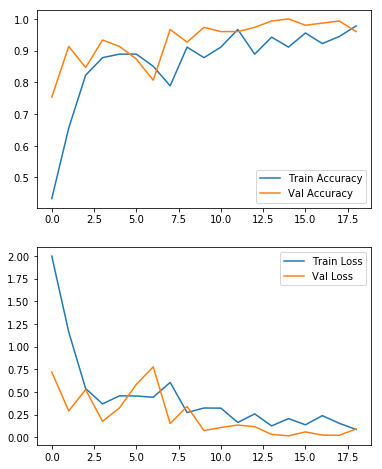

In [87]:
#plot out accuracy and loss
fig, ax=plt.subplots(2,1,figsize=(6,8))

ax[0].plot(history.history['acc'],label="Train Accuracy")
ax[0].plot(history.history['val_acc'],label="Val Accuracy")
ax[0].legend();

ax[1].plot(history.history['loss'],label="Train Loss")
ax[1].plot(history.history['val_loss'],label="Val Loss")
ax[1].legend();


# Try it out!

In [14]:
poshnet = load_model('vgg16v1.h5')

#define a function to predict item category
def get_category(image_path):
    labels = ['coats','dresses','pants','sweaters','tops']

    
    img=mpimg.imread(image_path)
    imgplot = plt.imshow(img)
    plt.show()

    image = load_img(image_path,target_size = (224,224))
    
    #convert the image pixels to a numpy array
    image = img_to_array(image)
    
    #reshape data for the model
    image = image.reshape((1,image.shape[0], image.shape[1], image.shape[2] ))
    #prepare the image for VGG model
    image = preprocess_input(image)
    
    yhat = poshnet.predict(image)

    index, value = max(enumerate(yhat[0]), key=operator.itemgetter(1))

    return labels[index], plt.bar(labels,[item for sublist in yhat.tolist() for item in sublist])


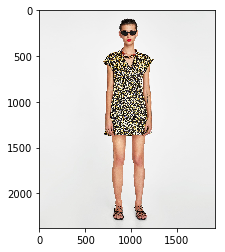

('dresses', <Container object of 5 artists>)

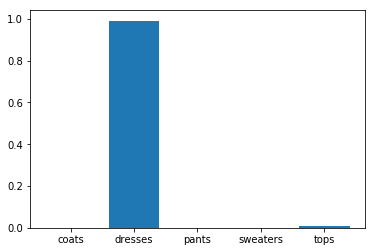

In [15]:
get_category('./zara/short.jpg')

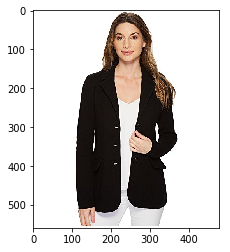

('coats', <Container object of 5 artists>)

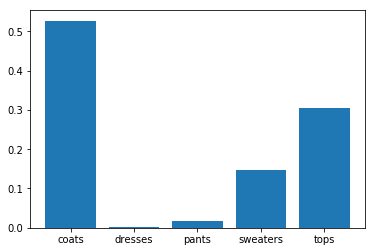

In [17]:
get_category('./zara/2.jpg')

In [18]:
def item_label(image_path):
    labels = ['coats','dresses','pants','sweaters','tops']
    
    img=mpimg.imread(image_path)

    image = load_img(image_path,target_size = (224,224))
    
    #convert the image pixels to a numpy array
    image = img_to_array(image)
    
    #reshape data for the model
    image = image.reshape((1,image.shape[0], image.shape[1], image.shape[2] ))
    #prepare the image for VGG model
    image = preprocess_input(image)
    
    yhat = poshnet.predict(image)

    index, value = max(enumerate(yhat[0]), key=operator.itemgetter(1))

    return labels[index]


# Similar style recommendation

In [19]:
model =load_model('vgg16final.h5')
model.layers
model.get_layer('last')


In [20]:
#extract weight matrix for each image from the intermediate layer, contains more information than just the category

intermediate = Model(inputs=model.input,outputs=model.get_layer('l2').output)

In [24]:
#use the weight matrix extracted from intermediate layer to predict on training images to get the style vector
stylevec = intermediate.predict_generator(train_generator)


input image


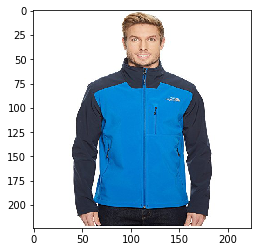

similar items


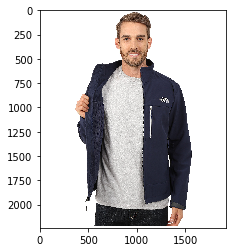

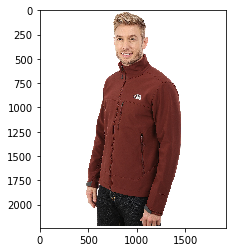

In [90]:
from scipy import spatial
from collections import defaultdict


#define a function to recommend item based on the style and category
def input_img(img_path2, recomended_category):
    
    #displaying image
    image = load_img(img_path2,target_size = (224,224))
    print('input image')
    imgplot = plt.imshow(image)
    plt.show()
    
    #convert image to style vectors
    image = img_to_array(image)
    image = image.reshape((1,image.shape[0], image.shape[1], image.shape[2] ))
    image = preprocess_input(image)
    imagevec = intermediate.predict(image)
    
 
    #compute the consine distance of input image with all images in train data
    cosdistances = []
    for i in range(stylevec.shape[0]):
        #returning items in the same category
        if item_label('./train/'+train_generator.filenames[i]) ==recomended_category:

            distance = spatial.distance.cosine(imagevec, stylevec[i].reshape(1,512))
            cosdistances.append((distance,i))

    #return the image index with the 2 shortest cosine distance
    imageindex = sorted(cosdistances)[:2]
    
    print('similar items')
    
    
    #display similar items 
    for i in [v[1] for v in imageindex]:
        path =train_generator.filenames[i]

        img=mpimg.imread('./train/'+path)
        item_category = path.split('/')[0]
        
        imgplot = plt.imshow(img)
        plt.show()
            
    return imagevec
            
    
iv = input_img('./zara/manjacket.jpg','coats')


input image


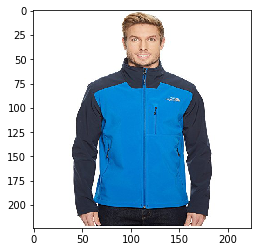

similar items


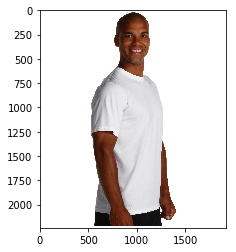

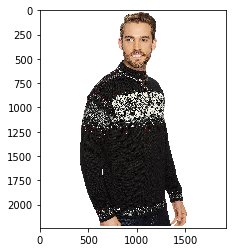

In [91]:
#have it to recommend similar tops
iv = input_img('./zara/manjacket.jpg','tops')


# Fashion transfer 

In [2]:
#define a grabcut function to cuout model and clothing area

import numpy as np
import cv2 
import random

def grabcut(rectangle_size, image_path):

    img = cv2.imread(image_path)

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    mask = np.zeros(img.shape[:2], np.uint8)

    bgdModel = np.zeros((1, 65), np.float64)
    fgdModel = np.zeros((1, 65), np.float64)

    #rect = (200,400,1800,2000) #x1,y2,w,h, rectangle size for pics in train/test
    rect =rectangle_size  #rectangle size for pics directly downloaded from zappos 

    cv2.grabCut(img,mask,rect,bgdModel,fgdModel,5,cv2.GC_INIT_WITH_RECT)

    mask2 = np.where((mask==2)|(mask==0), 0,1).astype('uint8')


    img = img*mask2[:,:, np.newaxis]

    cv2.imwrite('cropped.jpg',img)
    plt.imshow(img),plt.colorbar(),plt.show()

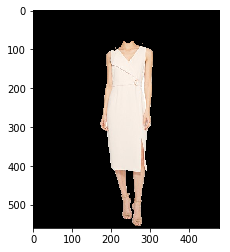

(<matplotlib.image.AxesImage at 0x7f37a83607f0>, None)

In [60]:
img = cv2.imread('./zara/thedress1.jpg')

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
mask = np.zeros(img.shape[:2], np.uint8)

bgdModel = np.zeros((1, 65), np.float64)
fgdModel = np.zeros((1, 65), np.float64)

#rect = (200,400,1800,2000) #x1,y2,w,h, rectangle size for pics in train/test
rect = (170,80,200,800)     #rectangle size for pics directly downloaded from zappos 

cv2.grabCut(img,mask,rect,bgdModel,fgdModel,5,cv2.GC_INIT_WITH_RECT)

mask2 = np.where((mask==2)|(mask==0), 0,1).astype('uint8')


img = img*mask2[:,:, np.newaxis]

cv2.imwrite('cropped.jpg',img)
plt.imshow(img),plt.show()



#grabcut((170,80,200,800),'./zara/thedress1.jpg')

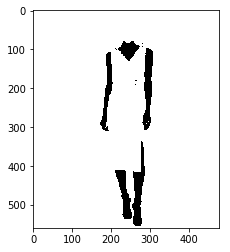

In [62]:
#creating a skin mask
# define the upper and lower boundaries of the HSV pixel intensities to be considered 'skin'

lower = np.array([0, 48, 80], dtype = "uint8")
upper = np.array([20, 255, 255], dtype = "uint8")


hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

skinmask = cv2.inRange(hsv, lower, upper)
test = cv2.bitwise_not(skinmask)
plt.imshow(test, 'gray')

True

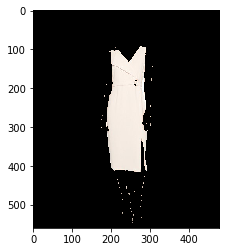

In [63]:
#apply the skin mask on the model picture

erode = cv2.erode(test,((15,15)))
a = cv2.bitwise_and(img,img,mask=erode)
plt.imshow(a)
cv2.imwrite('cropped.jpg',a)
#save the cropped dress img 




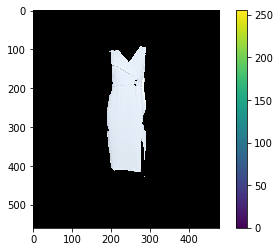

In [64]:
#remove noise from cropped picture 

a = grabcut((190,80,100,350),'cropped.jpg')


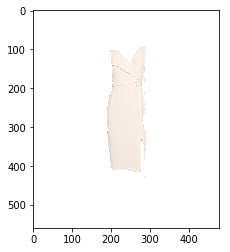

(<matplotlib.image.AxesImage at 0x7f37a80c0fd0>, None)

In [75]:
#change the background to transparent 
src = cv2.imread('cropped.jpg', 1)
tmp = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)
_,a1 = cv2.threshold(tmp,10,255,cv2.THRESH_BINARY)

b1, g1, r1 = cv2.split(src)
rgba = [r1,g1,b1, a1]
dst = cv2.merge(rgba,4)
cv2.imwrite("test1.jpg", dst)

test = cv2.imread('test1.jpg')
test = cv2.cvtColor(test, cv2.COLOR_BGR2RGB)
plt.imshow(dst),plt.show()

modelpic


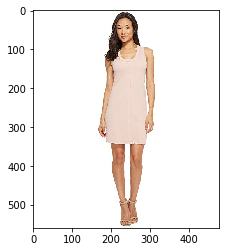

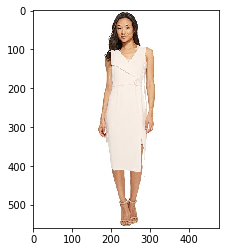

(<matplotlib.image.AxesImage at 0x7f37881b2898>, None)

In [112]:
#overlay clothe on top of the model 
#original ./minitest/dresses/2416281-1-4x.jpg
img2 = cv2.imread('./zara/model.jpg' )
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
print('modelpic')
plt.imshow(img2),plt.show()

r, g, b = cv2.split(img2)
a = np.array(b)
a*=0
a+=255
for i in range(b.shape[0]):
    for j in range(b.shape[1]):
        if a1[i][j]:
            b[i][j]=b1[i][j]
            g[i][j]=g1[i][j]
            r[i][j]=r1[i][j]


rgba = [r,g,b,a]
img2 = cv2.merge(rgba,4)


plt.imshow(img2),plt.show()

# output = cv2.add(img2,cropped)
# plt.imshow(output),plt.colorbar(),plt.show()

